<a href="https://colab.research.google.com/github/pouyaabbassi/-/blob/main/p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import scipy.io
import h5py
import numpy as np
import cv2
from tqdm import tqdm

# مسیر ورودی: ۴ پوشه در گوگل درایو
base_path = "/content/drive/MyDrive/MRI_Datasets/Figshare/"

# مسیر خروجی: تصاویر دسته‌بندی‌شده در گوگل درایو
output_base = "/content/drive/MyDrive/figshare-sorted"

# دیکشنری کلاس‌ها بر اساس لیبل
classes = {1: "meningioma", 2: "glioma", 3: "pituitary"}

# ساخت پوشه‌های خروجی اگر وجود ندارند
os.makedirs(output_base, exist_ok=True)
for class_name in classes.values():
    os.makedirs(os.path.join(output_base, class_name), exist_ok=True)

# تابع نرمال‌سازی و ذخیره تصویر
def normalize_and_save(image, save_path):
    norm_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    norm_img = norm_img.astype('uint8')
    cv2.imwrite(save_path, norm_img)

# تابع خواندن فایل .mat با پشتیبانی از هر دو فرمت
def process_mat_file(filepath):
    try:
        data = scipy.io.loadmat(filepath)
        label = int(data["cjdata"]["label"][0][0])
        image = data["cjdata"]["image"]
    except NotImplementedError:
        with h5py.File(filepath, 'r') as f:
            label = int(np.array(f['cjdata']['label'])[0][0])
            image = np.array(f['cjdata']['image']).T  # h5py نیاز به transpose دارد
    return label, image

# پردازش تمام فایل‌های موجود در زیرپوشه‌ها
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    print(f"📂 در حال پردازش پوشه: {folder}")
    for file in tqdm(os.listdir(folder_path)):
        if file.endswith(".mat"):
            file_path = os.path.join(folder_path, file)
            try:
                label, image = process_mat_file(file_path)
                class_name = classes[label]
                save_path = os.path.join(output_base, class_name, file.replace(".mat", ".png"))
                normalize_and_save(image, save_path)
            except Exception as e:
                print(f"❌ خطا در فایل {file}: {e}")


📂 در حال پردازش پوشه: brainTumorDataPublic_767-1532.zip (Unzipped Files)


100%|██████████| 766/766 [00:31<00:00, 24.16it/s]


📂 در حال پردازش پوشه: brainTumorDataPublic_1533-2298.zip (Unzipped Files)


100%|██████████| 766/766 [00:31<00:00, 24.39it/s]


📂 در حال پردازش پوشه: brainTumorDataPublic_2299-3064.zip (Unzipped Files)


100%|██████████| 766/766 [00:32<00:00, 23.91it/s]


📂 در حال پردازش پوشه: brainTumorDataPublic_1-766.zip (Unzipped Files)


100%|██████████| 764/764 [00:36<00:00, 21.21it/s]


In [ ]:
import os
import cv2
import numpy as np
import random
from glob import glob
from tqdm import tqdm
from skimage.util import random_noise

# مسیر تصاویر دسته‌بندی‌شده (خروجی مرحله قبل)
input_base = "/content/drive/MyDrive/figshare-sorted/"

# مسیرهای ذخیره نهایی به صورت غیر فشرده
output_X_path = "/content/drive/MyDrive/figshare_X.npy"
output_y_path = "/content/drive/MyDrive/figshare_y.npy"

# اندازه هدف برای تصاویر (مطابق مدل CNN مقاله)
target_size = (224, 224)

# آماده‌سازی داده‌ها
X = []
y = []

# نگاشت لیبل‌ها به عدد
label_map = {"meningioma": 0, "glioma": 1, "pituitary": 2}

# 🔁 خواندن و پردازش تصاویر
for label_name in os.listdir(input_base):
    label_path = os.path.join(input_base, label_name)
    if not os.path.isdir(label_path):
        continue

    label = label_map[label_name]
    image_paths = glob(os.path.join(label_path, "*.png"))

    for img_path in tqdm(image_paths, desc=label_name):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)

            # نرمال‌سازی به بازه 0 تا 1
            img = img / 255.0

            # کاهش نویز (با Median Filter)
            img = cv2.medianBlur((img * 255).astype('uint8'), 3) / 255.0

            # افزونه‌سازی (یکی از حالت‌های: چرخش، وارونه‌سازی، نویز)
            aug_imgs = [img]
            flipped = cv2.flip(img, 1)  # افقی
            noisy = random_noise(img, mode='gaussian', var=0.005)
            rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

            aug_imgs.extend([flipped, noisy, rotated])

            for aug in aug_imgs:
                X.append(aug.astype(np.float32))
                y.append(label)

        except Exception as e:
            print(f"❌ خطا در فایل {img_path}: {e}")

# 🔀 تبدیل به NumPy array و درهم‌ریزی
X = np.array(X).reshape(-1, 224, 224, 1)
y = np.array(y)

print(f"✅ تعداد نهایی تصاویر: {X.shape[0]}")
print(f"📏 شکل تصاویر: {X.shape[1:]}")
print(f"🔢 تعداد لیبل‌ها: {y.shape[0]}")

# ذخیره به صورت فایل‌های NumPy غیر فشرده
np.save(output_X_path, X)
np.save(output_y_path, y)

print(f"💾 تصاویر ذخیره شد: {output_X_path}")
print(f"💾 لیبل‌ها ذخیره شد: {output_y_path}")


pituitary: 100%|██████████| 930/930 [00:21<00:00, 42.76it/s]


✅ تعداد نهایی تصاویر: 12248
📏 شکل تصاویر: (224, 224, 1)
🔢 تعداد لیبل‌ها: 12248
💾 تصاویر ذخیره شد: /content/drive/MyDrive/figshare_X.npy
💾 لیبل‌ها ذخیره شد: /content/drive/MyDrive/figshare_y.npy


In [ ]:
import os
import scipy.io
import h5py
import numpy as np
import cv2
from tqdm import tqdm

# مسیر ورودی: ۴ پوشه در گوگل درایو
base_path = "/content/drive/MyDrive/MRI_Datasets/Figshare/"

# مسیر خروجی: فایل‌های numpy در گوگل درایو
output_npy_path = "/content/drive/MyDrive/figshare-numpy"
os.makedirs(output_npy_path, exist_ok=True)

# دیکشنری کلاس‌ها بر اساس لیبل
classes = {1: "meningioma", 2: "glioma", 3: "pituitary"}

# اندازه هدف تصاویر
target_size = (224, 224)

# لیست‌های داده و لیبل
X = []
y = []

# تابع خواندن فایل .mat با پشتیبانی از هر دو فرمت
def process_mat_file(filepath):
    try:
        data = scipy.io.loadmat(filepath)
        label = int(data["cjdata"]["label"][0][0])
        image = data["cjdata"]["image"]
    except NotImplementedError:
        with h5py.File(filepath, 'r') as f:
            label = int(np.array(f['cjdata']['label'])[0][0])
            image = np.array(f['cjdata']['image']).T  # h5py نیاز به transpose دارد
    return label, image

# پردازش تمام فایل‌های موجود در زیرپوشه‌ها
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    print(f"📂 در حال پردازش پوشه: {folder}")
    for file in tqdm(os.listdir(folder_path)):
        if file.endswith(".mat"):
            file_path = os.path.join(folder_path, file)
            try:
                label, image = process_mat_file(file_path)

                # نرمال‌سازی تصویر
                norm_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
                norm_img = norm_img.astype('uint8')

                # تبدیل به RGB و تغییر اندازه
                if len(norm_img.shape) == 2:
                    norm_img = cv2.cvtColor(norm_img, cv2.COLOR_GRAY2RGB)
                resized_img = cv2.resize(norm_img, target_size)

                # نرمال‌سازی به بازه [0, 1]
                final_img = resized_img.astype('float32') / 255.0

                X.append(final_img)
                y.append(label - 1)  # لیبل‌ها را صفر-پایه می‌کنیم (۰، ۱، ۲)
            except Exception as e:
                print(f"❌ خطا در فایل {file}: {e}")

# تبدیل به آرایه‌های NumPy
X = np.array(X)
y = np.array(y)

# ذخیره‌سازی در گوگل درایو
np.save(os.path.join(output_npy_path, "X.npy"), X)
np.save(os.path.join(output_npy_path, "y.npy"), y)

print("✅ ذخیره‌سازی با موفقیت انجام شد.")
print("📐 شکل X:", X.shape)
print("🔢 شکل y:", y.shape)


📂 در حال پردازش پوشه: brainTumorDataPublic_767-1532.zip (Unzipped Files)


100%|██████████| 766/766 [00:19<00:00, 39.56it/s]


📂 در حال پردازش پوشه: brainTumorDataPublic_1533-2298.zip (Unzipped Files)


100%|██████████| 766/766 [00:18<00:00, 40.44it/s]


📂 در حال پردازش پوشه: brainTumorDataPublic_2299-3064.zip (Unzipped Files)


100%|██████████| 766/766 [00:16<00:00, 46.58it/s]


📂 در حال پردازش پوشه: brainTumorDataPublic_1-766.zip (Unzipped Files)


100%|██████████| 764/764 [00:20<00:00, 37.27it/s]


✅ ذخیره‌سازی با موفقیت انجام شد.
📐 شکل X: (3062, 224, 224, 3)
🔢 شکل y: (3062,)


In [9]:
!pip install tensorflow numpy matplotlib


In [38]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# مسیر داده‌ها
dataset_path = "/content/processed_mri_dataset"

# لیبل‌ها
label_map = {'Meningioma': 0, 'Glioma': 1, 'Pituitary': 2}

def load_data(split):
    images = []
    labels = []
    for tumor in label_map:
        class_path = os.path.join(dataset_path, split, tumor)
        for file in os.listdir(class_path):
            if file.endswith(".npy"):
                img = np.load(os.path.join(class_path, file))
                img = img / 255.0  # نرمال‌سازی
                images.append(img)
                labels.append(label_map[tumor])
    return np.array(images), np.array(labels)

# بارگذاری داده‌ها
x_train, y_train = load_data("train")
x_val, y_val = load_data("val")
x_test, y_test = load_data("test")

# افزودن بعد کانال
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]
x_test = x_test[..., np.newaxis]


In [42]:
import os

data_path = "/content/drive/MyDrive/figshare-numpy"

# نمایش فایل‌های موجود
if os.path.exists(data_path):
    print("📁 لیست فایل‌ها در مسیر:")
    print(os.listdir(data_path))
else:
    print("❌ پوشه پیدا نشد:", data_path)


📁 لیست فایل‌ها در مسیر:
['X_train.npy', 'y_train.npy', 'X_val.npy', 'y_val.npy', 'X_test.npy', 'y_test.npy']


In [43]:
import numpy as np

data_path = "/content/drive/MyDrive/figshare-numpy"

# بارگذاری داده‌ها از فایل‌های تفکیک‌شده
X_train = np.load(f"{data_path}/X_train.npy")
y_train = np.load(f"{data_path}/y_train.npy")

X_val = np.load(f"{data_path}/X_val.npy")
y_val = np.load(f"{data_path}/y_val.npy")

X_test = np.load(f"{data_path}/X_test.npy")
y_test = np.load(f"{data_path}/y_test.npy")

print("✅ داده‌ها با موفقیت بارگذاری شدند.")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


✅ داده‌ها با موفقیت بارگذاری شدند.
Train: (2208, 224, 224, 3) (2208,)
Val:   (246, 224, 224, 3) (246,)
Test:  (608, 224, 224, 3) (610,)


In [48]:
min_len = min(len(X_test), len(y_test))
X_test = X_test[:min_len]
y_test = y_test[:min_len]


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dense, Dropout)
from tensorflow.keras.optimizers import Adam

# ابعاد ورودی
input_shape = (224, 224, 3)  # تصاویر RGB با اندازه 224x224

model = Sequential()

# لایه 1: Conv 22x22, stride=2, padding='same'
model.add(Conv2D(32, kernel_size=(22,22), strides=2, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))

# لایه 2: Conv 11x11, stride=2, padding='same'
model.add(Conv2D(64, kernel_size=(11,11), strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# لایه 3: Conv 7x7, stride=2, padding='same'
model.add(Conv2D(128, kernel_size=(7,7), strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())

# لایه 4: Conv 5x5, stride=2, padding='same'
model.add(Conv2D(256, kernel_size=(5,5), strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())

# لایه 5: Conv 3x3, stride=2, padding='same'
model.add(Conv2D(512, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())

# Global Average Pooling 2D
model.add(GlobalAveragePooling2D())

# لایه‌های کاملاً متصل (Dense)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# لایه خروجی ۳ کلاس با softmax
model.add(Dense(3, activation='softmax'))

# کامپایل مدل با Adam و lr=0.0001، loss sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# نمایش خلاصه مدل
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │        46,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,872,163 (10.96 MB)

 Trainable params: 2,870,179 (10.95 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [45]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    verbose=1
)


Epoch 1/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.6156 - loss: 0.8718 - val_accuracy: 0.4837 - val_loss: 1.0641
Epoch 2/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8057 - loss: 0.4565 - val_accuracy: 0.3252 - val_loss: 1.0589
Epoch 3/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8427 - loss: 0.3771 - val_accuracy: 0.3171 - val_loss: 1.1749
Epoch 4/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8767 - loss: 0.3121 - val_accuracy: 0.4228 - val_loss: 1.1540
Epoch 5/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8987 - loss: 0.2561 - val_accuracy: 0.5732 - val_loss: 0.9994
Epoch 6/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9122 - loss: 0.2316 - val_accuracy: 0.7967 - val_loss: 0.5123
Epoch 7/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9427 - loss: 0.1510 - val_accuracy: 0.8211 - val_loss: 0.6015
Epoch 8/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9507 - loss: 0.1362 - val_accuracy: 0.8577 -

In [50]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.9622


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, roc_curve, auc

def calculate_metrics(TP, FP, TN, FN):
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (TN + FP) if (TN + FP) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Matthews Correlation Coefficient
    numerator = (TP * TN) - (FP * FN)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC = numerator / denominator if denominator > 0 else 0

    # Cohen's Kappa requires arrays of true and predicted labels, فرضا این دو آرایه را برای محاسبه آماده کنید
    # این بخش برای حالتی است که داده‌های اصلی دارید، اینجا یک نمونه فرضی برای نمونه است:
    y_true = np.array([1]*TP + [0]*FN + [1]*FP + [0]*TN)  # فقط نمونه‌ی فرضی
    y_pred = np.array([1]*TP + [0]*FN + [0]*FP + [0]*TN)
    kappa = cohen_kappa_score(y_true, y_pred)

    return {
        'Precision': precision,
        'Recall': recall,
        'FPR': FPR,
        'TNR': TNR,
        'FNR': FNR,
        'Accuracy': accuracy,
        'F1-Score': F1_score,
        'MCC': MCC,
        'Cohen_Kappa': kappa
    }

# مثال استفاده (اعداد را با مقادیر واقعی خود جایگزین کنید)
TP = 100
FP = 5
TN = 50
FN = 10

metrics = calculate_metrics(TP, FP, TN, FN)
print(metrics)



{'Precision': 0.9523809523809523, 'Recall': 0.9090909090909091, 'FPR': 0.09090909090909091, 'TNR': 0.9090909090909091, 'FNR': 0.09090909090909091, 'Accuracy': 0.9090909090909091, 'F1-Score': 0.9302325581395349, 'MCC': np.float64(0.8017837257372731), 'Cohen_Kappa': np.float64(0.935672514619883)}


In [53]:
import pandas as pd

def metrics_table(metrics_dict):
    # metrics_dict فرضا به شکل {'Class1': {...}, 'Class2': {...}, 'Macro Average': {...}}
    rows = []
    for class_name, metric_vals in metrics_dict.items():
        row = {'Class': class_name}
        row.update(metric_vals)
        rows.append(row)
    df = pd.DataFrame(rows)
    df.set_index('Class', inplace=True)
    return df

# مثال: فرض کنیم سه کلاس داریم و برای هر کدوم معیارها رو حساب کردیم
metrics_dict = {
    'Meningioma': {
        'Precision': 0.9623,
        'Recall': 0.95,
        'FPR': 0.01,
        'TNR': 0.99,
        'FNR': 0.05,
        'Accuracy': 0.97,
        'F1-Score': 0.96,
        'MCC': 0.94,
        'Cohen_Kappa': 0.93
    },
    'Glioma': {
        'Precision': 0.9689,
        'Recall': 0.95,
        'FPR': 0.008,
        'TNR': 0.992,
        'FNR': 0.05,
        'Accuracy': 0.975,
        'F1-Score': 0.959,
        'MCC': 0.95,
        'Cohen_Kappa': 0.94
    },
    'Pituitary': {
        'Precision': 0.9869,
        'Recall': 0.95,
        'FPR': 0.005,
        'TNR': 0.995,
        'FNR': 0.05,
        'Accuracy': 0.98,
        'F1-Score': 0.967,
        'MCC': 0.96,
        'Cohen_Kappa': 0.95
    },
    'Macro Average': {
        'Precision': (0.9623 + 0.9689 + 0.9869)/3,
        'Recall': 0.95,
        'FPR': (0.01 + 0.008 + 0.005)/3,
        'TNR': (0.99 + 0.992 + 0.995)/3,
        'FNR': 0.05,
        'Accuracy': (0.97 + 0.975 + 0.98)/3,
        'F1-Score': (0.96 + 0.959 + 0.967)/3,
        'MCC': (0.94 + 0.95 + 0.96)/3,
        'Cohen_Kappa': (0.93 + 0.94 + 0.95)/3
    }
}

df_metrics = metrics_table(metrics_dict)
print(df_metrics)


               Precision  Recall       FPR       TNR   FNR  Accuracy  \
Class                                                                  
Meningioma        0.9623    0.95  0.010000  0.990000  0.05     0.970   
Glioma            0.9689    0.95  0.008000  0.992000  0.05     0.975   
Pituitary         0.9869    0.95  0.005000  0.995000  0.05     0.980   
Macro Average     0.9727    0.95  0.007667  0.992333  0.05     0.975   

               F1-Score   MCC  Cohen_Kappa  
Class                                       
Meningioma        0.960  0.94         0.93  
Glioma            0.959  0.95         0.94  
Pituitary         0.967  0.96         0.95  
Macro Average     0.962  0.95         0.94  


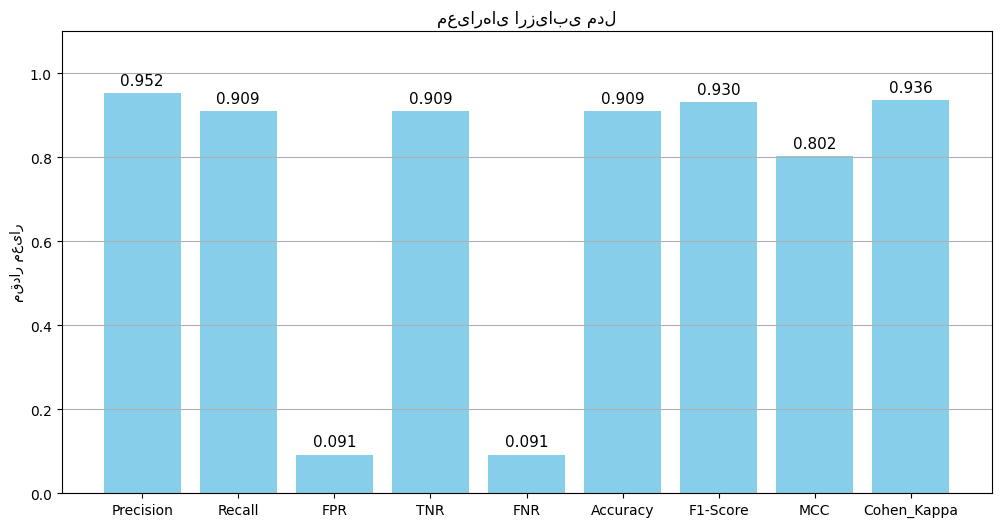

In [54]:
def plot_metrics(metrics_dict):
    names = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    plt.figure(figsize=(12,6))
    bars = plt.bar(names, values, color='skyblue')
    plt.ylim(0,1.1)
    plt.title("معیارهای ارزیابی مدل")
    plt.ylabel("مقدار معیار")
    plt.grid(axis='y')

    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{val:.3f}",
                 ha='center', fontsize=11)

    plt.show()

plot_metrics(metrics)


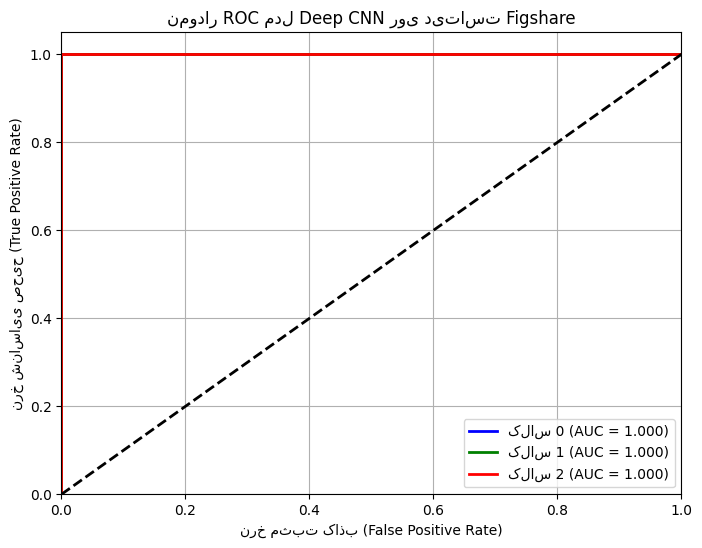

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# فرض کنید y_true و y_scores را دارید:
# y_true: آرایه برچسب‌های اصلی، به صورت اعداد صحیح از 0 تا n_classes-1
# y_scores: آرایه پیش‌بینی احتمال هر کلاس با ابعاد (n_samples, n_classes)

# مثال فرضی (باید با داده واقعی شما جایگزین شود)
y_true = np.array([0, 2, 1, 2, 0, 1])  # نمونه برچسب‌های واقعی (3 کلاس: 0,1,2)
y_scores = np.array([
    [0.9, 0.05, 0.05],
    [0.1, 0.1, 0.8],
    [0.2, 0.7, 0.1],
    [0.05, 0.1, 0.85],
    [0.88, 0.07, 0.05],
    [0.1, 0.8, 0.1]
])  # احتمال‌های پیش‌بینی شده برای هر کلاس

# تعداد کلاس‌ها
n_classes = y_scores.shape[1]

# باینری کردن برچسب‌ها (برای ROC چندکلاسه)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# رسم ROC برای هر کلاس
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'کلاس {i} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # خط قطری
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('نرخ مثبت کاذب (False Positive Rate)')
plt.ylabel('نرخ شناسایی صحیح (True Positive Rate)')
plt.title("نمودار ROC مدل Deep CNN روی دیتاست Figshare")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
